# belief eye ICA, neural activity

In [87]:
datafile='0404normzica.nbedata'
embeddingfile='0404normzica_0404.pt'

### imports

In [88]:
%reload_ext autoreload
%autoreload 2

In [89]:
# import
from scipy.stats import spearmanr, kendalltau
from sklearn.feature_selection import mutual_info_regression
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import FastICA
import torch
torch.cuda.is_available()
from neural_plot_ult import *
from matplotlib import pyplot as plt
import numpy as np
import cebra
from cebra import CEBRA
import pandas as pd
import tempfile
from pathlib import Path
import sys
import os
import pickle
from pathlib import Path
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import FastICA
from scipy.stats import pearsonr

In [90]:
try:
    config
except:
    import configparser
    config = configparser.ConfigParser()
    config.read_file(open('../../privateconfig'))
    resdir = Path(config['Datafolder']['data'])
    workdir = Path(config['Codefolder']['workspace'])
    os.chdir(workdir)


In [91]:

from notification import notify

In [92]:
# real data
with open(f'{workdir}/test/neural/cebra/{datafile}', 'rb') as f:
    (neural_data, continuous_label, var_names) = pickle.load(f)

var_names

['sess_latentff_hori',
 'sess_latentff_vert',
 'sess_eye_hori',
 'sess_eye_vert',
 'sess_latentb_hori',
 'sess_latentb_vert',
 '(sess_angle_from_start)',
 'sess_ll_t',
 'sess_t',
 'sess_err',
 'sess_err_belief',
 'sess_angle_from_start_belief',
 'belief_heading',
 'ica belief eye 1',
 'ica belief eye 2']

### neural embedding model

In [93]:
# load trained model
single_cebra_model = cebra.CEBRA.load(
    f'{workdir}/test/neural/cebra/{embeddingfile}')
embedding = single_cebra_model.transform(neural_data)

## visualize the ICA vs belief and eye

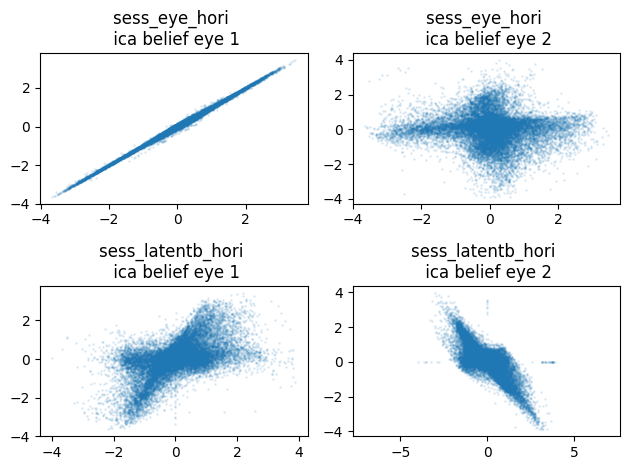

In [94]:

thisvarname=['belief', 'eye']
fig, axs = plt.subplots(2,2)
for i, ii in enumerate([2,4]):
    for j, jj in enumerate([13,14]):
        ax=axs[i,j]
        ax.scatter(continuous_label[:,ii],continuous_label[:,jj], s=1, alpha=0.1)
        plt.axis('equal')
        ax.set_title(f'{var_names[ii]} \n {var_names[jj]}')
plt.tight_layout()


## visualize the ica in 3d embedding 

In [95]:
# beh_idx    =      13
# %matplotlib widget
# fig = plt.figure(figsize=(5,5))
# ax1 = plt.subplot(111, projection='3d')
# ax1=plot_embedding(ax1, embedding, continuous_label, beh_idx=beh_idx)

# ax1.set_title(f'CEBRA behavior, {var_names[beh_idx]}')

# plt.show()


In [96]:
# beh_idx    =      14
# %matplotlib widget
# fig = plt.figure(figsize=(5,5))
# ax1 = plt.subplot(111, projection='3d')
# ax1=plot_embedding(ax1, embedding, continuous_label, beh_idx=beh_idx)

# ax1.set_title(f'CEBRA behavior, {var_names[beh_idx]}')

# plt.show()


obvious gradient

## visualize the ica in 2d embedding 

In [97]:
# # generate relavent figure (eg, hori to hori)
# %matplotlib inline
# tag='ica'

# for taskvar1 in range(len(var_names)):
#     if tag not in var_names[taskvar1]: continue
#     fig = plt.figure(figsize=(6,4))
#     ax1 = plt.subplot(111)
#     ax1=plot_embedding2d(ax1, embedding, continuous_label, beh_idx=taskvar1)

#     ax1.set_title(f'CEBRA behavior, {var_names[taskvar1]}')

#     plt.show()



gradient not very obvious

# ICA(taskvar-neural shared latent, taskvar)

## use raw neurons

In [98]:
neural_data.shape, continuous_label[:,[13,14]].shape

((18985, 94), (18985, 2))

### CCA(neural activity, task variables)

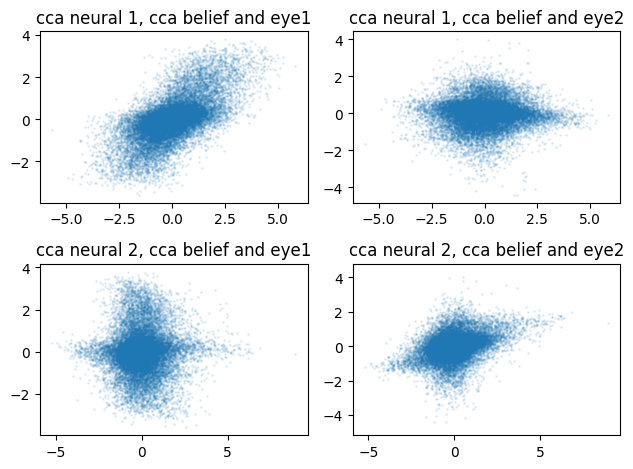

In [99]:
cca = CCA(n_components=2)
related_taskvar=continuous_label[:,[4,2]]
cca_neural, cca_be=cca.fit_transform(neural_data, related_taskvar)

fig, axs = plt.subplots(2,2)
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(cca_neural[:,i],cca_be[:,j], s=1, alpha=0.1)
        plt.axis('equal')
        ax.set_title(f'cca neural {i+1}, cca belief and eye{j+1}')
plt.tight_layout()

### ICA(cca latent, task variables)

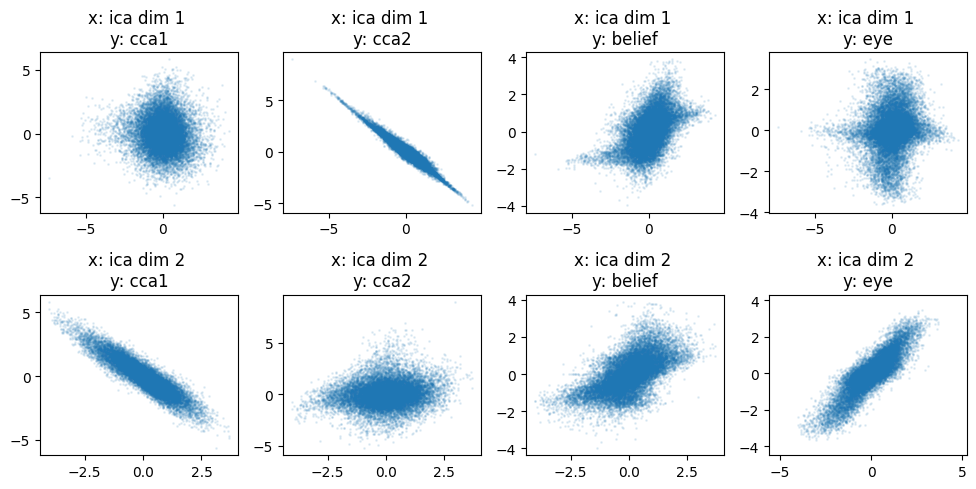

In [100]:
%matplotlib inline
ica = FastICA(n_components=2)
icaX=np.hstack([cca_neural,related_taskvar])
icaS = ica.fit_transform(icaX) 

varname=['cca1','cca2','belief', 'eye']
fig, axs = plt.subplots(2,4, figsize=(10,5))
for i in range(2):
    for j in range(4):
        ax=axs[i,j]
        ax.scatter(icaS[:,i],icaX[:,j], s=1, alpha=0.1)
        plt.axis('equal')
        ax.set_title(f'x: ica dim {i+1} \ny: {varname[j]}')
plt.tight_layout()


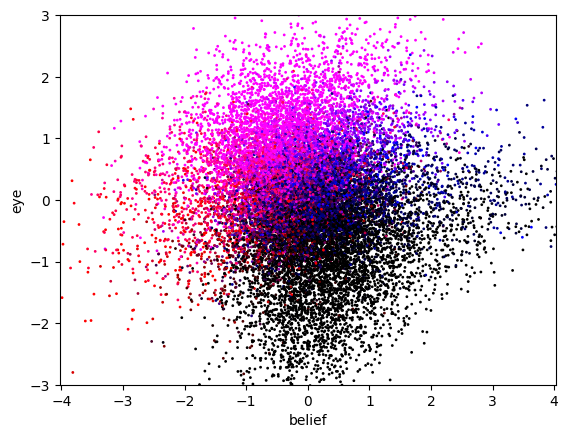

In [180]:


ica = FastICA(n_components=2)
icaX=np.hstack([cca_neural,related_taskvar])
icaS = ica.fit_transform(icaX) 

thisx,thisy=icaS[:,0], icaS[:,1]
t1,t2=icaX[:,2],icaX[:,3]

c1=np.array([1,0,0])
c2=np.array([0,0,1])
rgb_values=np.zeros((len(t1), 3))
rgb_values[:,[0,2]]=0.3
# rgb_values.shape, c1.shape, t1.shape
rgb_values+=(c1[:, None]*t1).T
rgb_values+=(c2[:, None]*t2).T

rgb_values=(rgb_values)
rgb_values=rgb_values.clip(0,1)
hex_colors = [mcolors.rgb2hex(color) for color in rgb_values]
plt.scatter(thisx, thisy, c=hex_colors,s=1)
plt.xlabel('belief')
plt.ylabel('eye')
# plt.title('Scatter Plot with RGB Colors')
plt.axis('equal')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()



In [75]:
ica.mixing_[:2,1]

array([ 1.16587033, -0.16563152])

In [76]:
a=np.inner(ica.mixing_[:2,0],ica.mixing_[:2,1])
b=a/np.linalg.norm(ica.mixing_[:2,0])/np.linalg.norm(ica.mixing_[:2,1])
np.rad2deg(np.arccos(b))


86.42422753511305

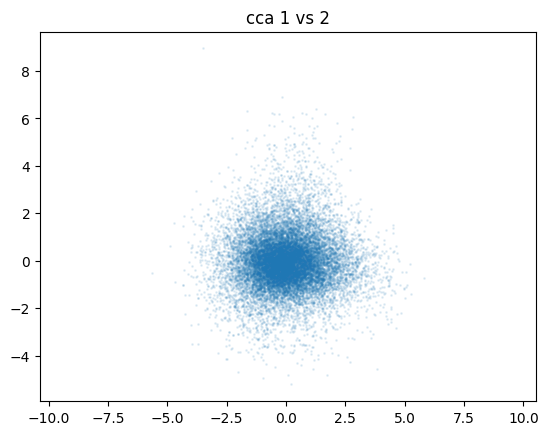

Text(0.5, 1.0, 'ica 1 vs 2')

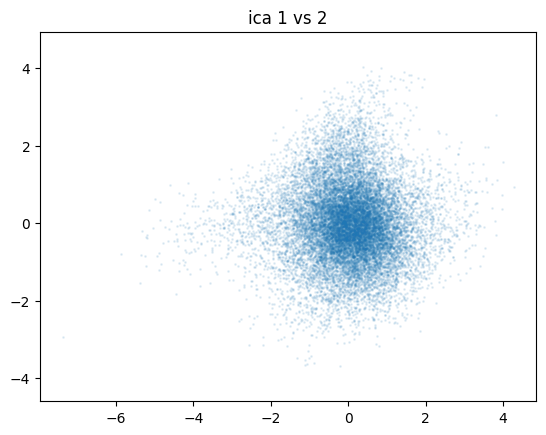

In [77]:
plt.scatter(cca_neural[:,0], cca_neural[:,1], s=1, alpha=0.1)
plt.title('cca 1 vs 2')
plt.axis('equal')
plt.show()
plt.scatter(icaS[:,0], icaS[:,1], s=1, alpha=0.1)
plt.axis('equal')
plt.title('ica 1 vs 2')


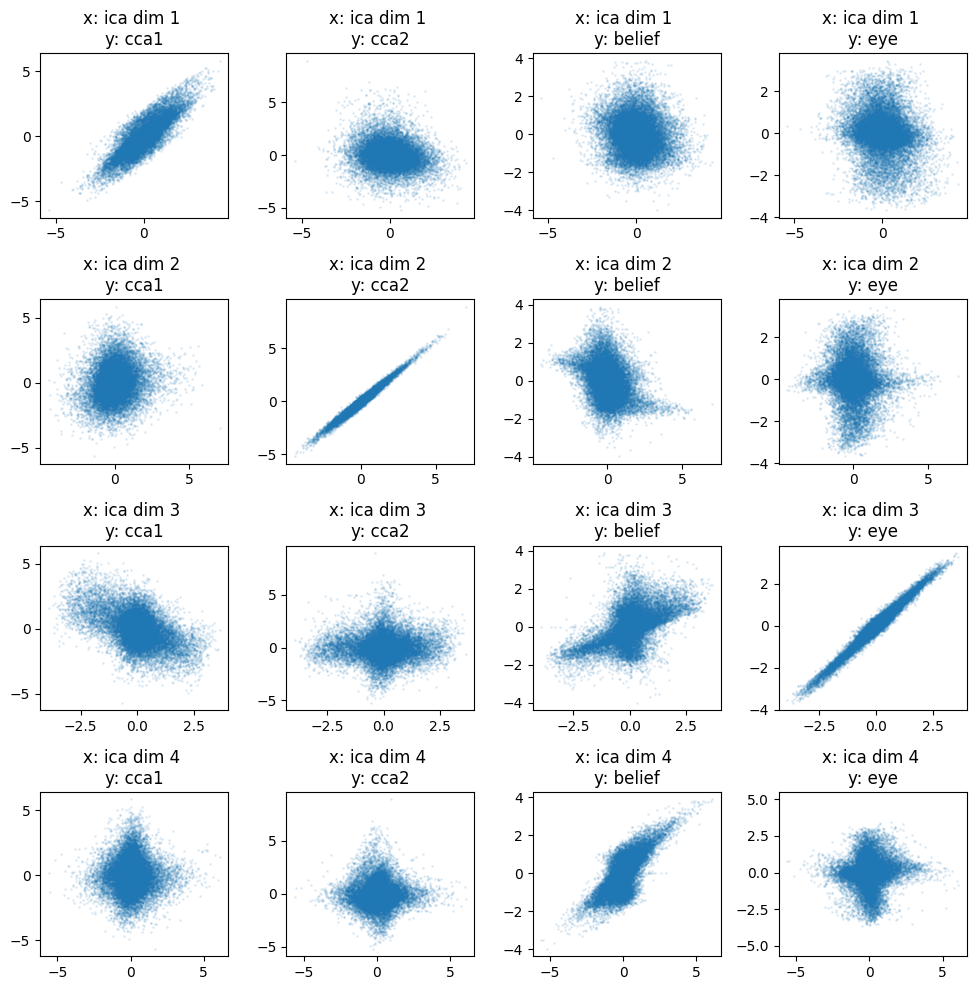

In [78]:
%matplotlib inline
ica = FastICA(n_components=4)
icaX=np.hstack([cca_neural,related_taskvar])
icaS = ica.fit_transform(icaX) 

varname=['cca1','cca2','belief', 'eye']
fig, axs = plt.subplots(4,4, figsize=(10,10))
for i in range(4):
    for j in range(4):
        ax=axs[i,j]
        ax.scatter(icaS[:,i],icaX[:,j], s=1, alpha=0.1)
        plt.axis('equal')
        ax.set_title(f'x: ica dim {i+1} \ny: {varname[j]}')
plt.tight_layout()


In [79]:
ica.mixing_

array([[ 1.08762931,  0.19332087, -0.64348692,  0.01573056],
       [-0.18484657,  1.14716413,  0.03300366,  0.03249723],
       [-0.1167812 , -0.32484019,  0.53132432,  0.72787227],
       [-0.1642326 , -0.03777001,  0.98385452,  0.06026087]])

## use raw neurons, cca only

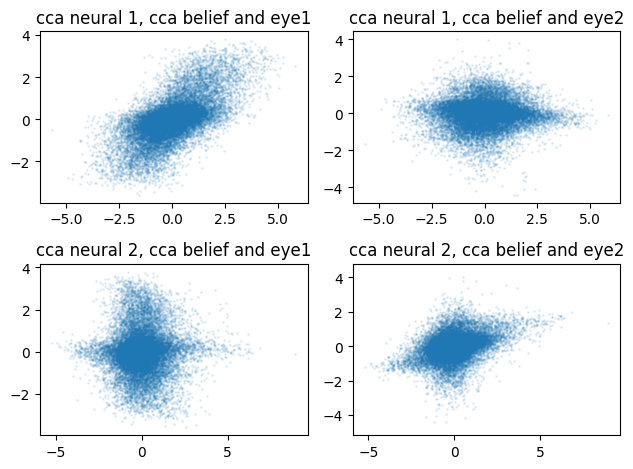

In [138]:
cca = CCA(n_components=2)
related_taskvar=continuous_label[:,[4,2]]
cca_neural, cca_be=cca.fit_transform(neural_data, related_taskvar)

fig, axs = plt.subplots(2,2)
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(cca_neural[:,i],cca_be[:,j], s=1, alpha=0.1)
        plt.axis('equal')
        ax.set_title(f'cca neural {i+1}, cca belief and eye{j+1}')
plt.tight_layout()

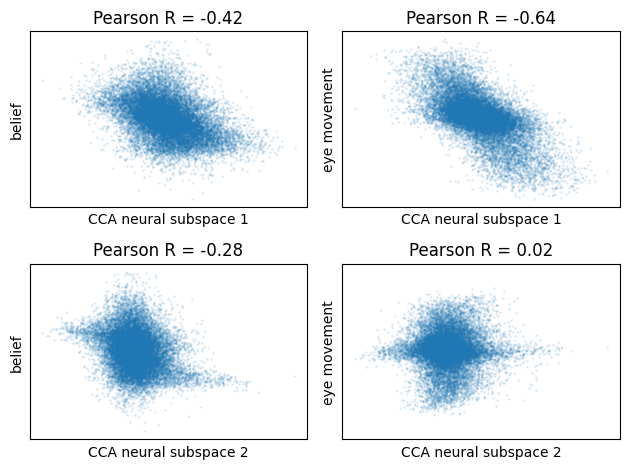

In [139]:


from scipy.stats import pearsonr
fig, axs = plt.subplots(2,2)
for i in range(2):
    for j,var in enumerate(['belief', 'eye movement']):
        ax=axs[i,j]
        ax.scatter(cca_neural[:,i],related_taskvar[:,j], s=1, alpha=0.1)
        plt.axis('equal')
        r=pearsonr(cca_neural[:,i],related_taskvar[:,j])[0]
        ax.set_title(f'Pearson R = {r:.2f}')
        ax.set_xlabel(f'CCA neural subspace {i+1}')
        ax.set_ylabel(f'{var}')
        ax.set_xticks([])
        ax.set_yticks([])
plt.tight_layout()
plt.show()


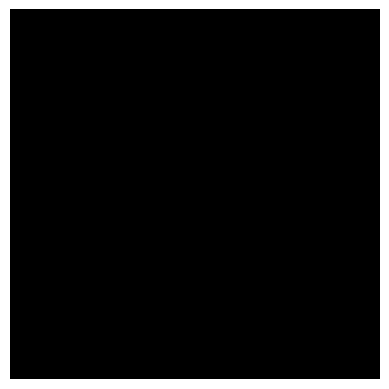

In [162]:
import numpy as np
import matplotlib.pyplot as plt

# Define the size of the gradient image
width = 10
height = 10

# Create a gradient from white to red (left to right)
gradient_lr = np.linspace(0, 1, width)
gradient_lr = np.stack((gradient_lr, np.zeros_like(gradient_lr), np.zeros_like(gradient_lr)), axis=-1)  # Red channel

# Create a gradient from white to blue (bottom to top)
gradient_tb = np.linspace(0, 1, height)
gradient_tb = np.stack((np.zeros_like(gradient_tb), np.fzeros_like(gradient_tb), gradient_tb), axis=-1)  # Blue channel

# Create the combined gradient image
gradient_image = np.zeros((height, width, 3))
for i in range(3):
    gradient_image[:, :, i] = gradient_lr[:, i] * gradient_tb[:, i]

# Plot the gradient image
plt.imshow(gradient_image, interpolation='nearest')
plt.axis('off')
plt.show()


In [159]:
c1=np.array([1,0,0])
c2=np.array([0,0,1])
rgb_values=np.zeros((100, 3))

np.linspace(np.zeros_like(c1), c1, 100)
np.linspace(np.zeros_like(c2), c2, 100)




array([0., 0., 0., ..., 0., 0., 0.])

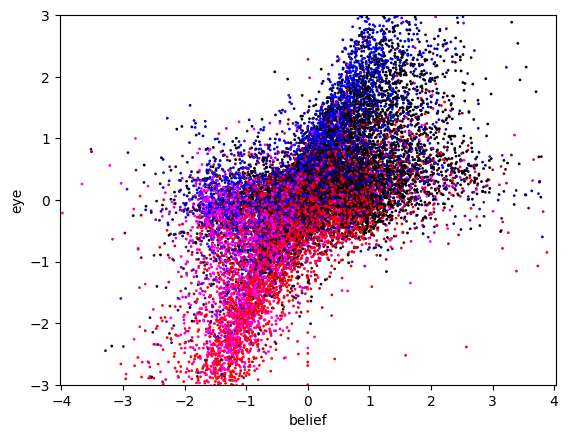

In [179]:

thisx,thisy=related_taskvar[:,0], related_taskvar[:,1]
t1,t2=cca_neural[:,0],cca_neural[:,1]

c1=np.array([1,0,0])
c2=np.array([0,0,1])
rgb_values=np.zeros((len(t1), 3))
rgb_values[:,[0,2]]=0.3
# rgb_values.shape, c1.shape, t1.shape
rgb_values+=(c1[:, None]*t1).T
rgb_values+=(c2[:, None]*t2).T

rgb_values=(rgb_values)
rgb_values=rgb_values.clip(0,1)
hex_colors = [mcolors.rgb2hex(color) for color in rgb_values]
plt.scatter(thisx, thisy, c=hex_colors,s=1)
plt.xlabel('belief')
plt.ylabel('eye')
# plt.title('Scatter Plot with RGB Colors')
plt.axis('equal')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.show()



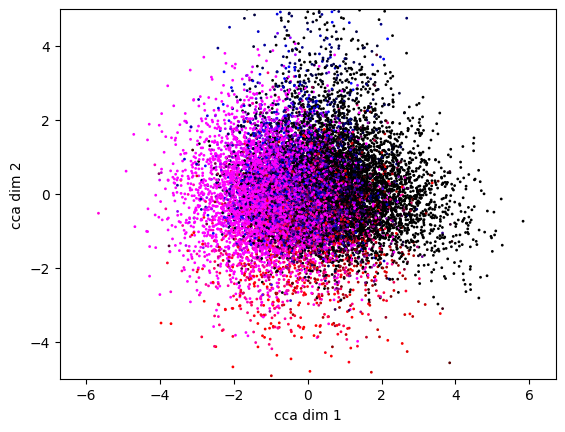

In [177]:

thisx,thisy=cca_neural[:,0],cca_neural[:,1]
t1,t2=related_taskvar[:,0], related_taskvar[:,1]
c1=np.array([1,0,0])
c2=np.array([0,0,1])
rgb_values=np.zeros((len(t1), 3))
rgb_values[:,[0,2]]=0.3
# rgb_values.shape, c1.shape, t1.shape
rgb_values+=(c1[:, None]*t1).T
rgb_values+=(c2[:, None]*t2).T

rgb_values=(rgb_values)
rgb_values=rgb_values.clip(0,1)
hex_colors = [mcolors.rgb2hex(color) for color in rgb_values]
plt.scatter(thisx, thisy, c=hex_colors,s=1)
plt.xlabel('cca dim 1')
plt.ylabel('cca dim 2')
# plt.title('Scatter Plot with RGB Colors')
plt.axis('equal')
plt.xlim(-5,5)
plt.ylim(-5,5)
plt.show()



In [ ]:

rgb_values+=c1.reshape(1,-1)*t1
rgb_values+=c2.reshape(1,-1)*t2


# Convert RGB values to hexadecimal strings
hex_colors = [mcolors.rgb2hex(color) for color in rgb_values]

# Plot scatter plot
plt.scatter(thisx, thisy, c=hex_colors)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot with RGB Colors')
plt.show()


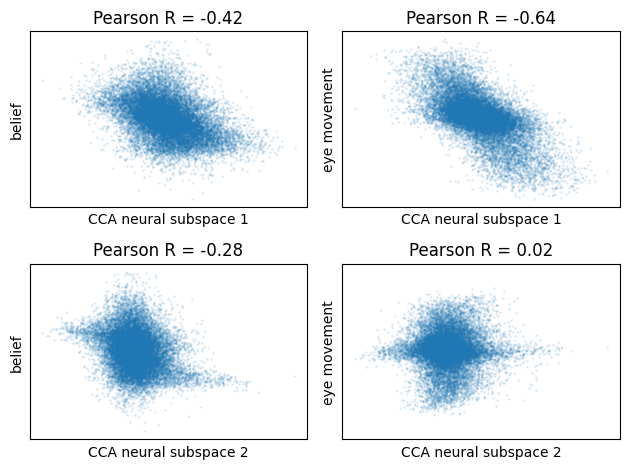

In [81]:
from scipy.stats import pearsonr
fig, axs = plt.subplots(2,2)
for i in range(2):
    for j,var in enumerate(['belief', 'eye movement']):
        ax=axs[i,j]
        ax.scatter(cca_neural[:,i],related_taskvar[:,j], s=1, alpha=0.1)
        plt.axis('equal')
        r=pearsonr(cca_neural[:,i],related_taskvar[:,j])[0]
        ax.set_title(f'Pearson R = {r:.2f}')
        ax.set_xlabel(f'CCA neural subspace {i+1}')
        ax.set_ylabel(f'{var}')
        ax.set_xticks([])
        ax.set_yticks([])
plt.tight_layout()

## use neural embedding

### CCA(neural embedding, task variables)

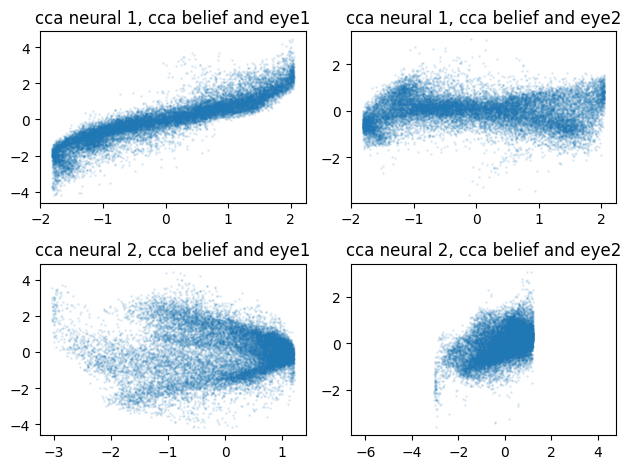

In [82]:


cca = CCA(n_components=2)
related_taskvar=continuous_label[:,[4,2]]
cca_neural, cca_be=cca.fit_transform(embedding, related_taskvar)

fig, axs = plt.subplots(2,2)
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(cca_neural[:,i],cca_be[:,j], s=1, alpha=0.1)
        plt.axis('equal')
        ax.set_title(f'cca neural {i+1}, cca belief and eye{j+1}')
plt.tight_layout()

### ICA(cca latent, task variables)

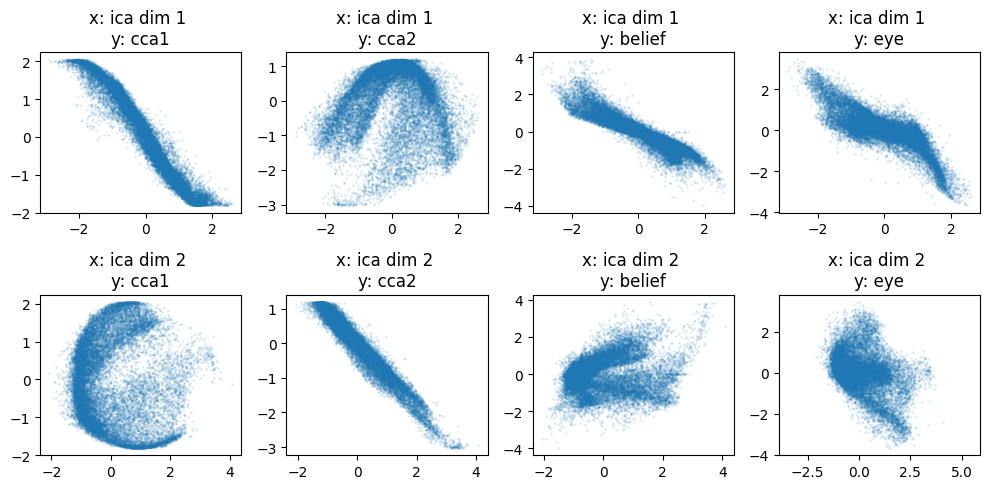

In [83]:

ica = FastICA(n_components=2)
icaX=np.hstack([cca_neural,related_taskvar])
icaS = ica.fit_transform(icaX) 

varname=['cca1','cca2','belief', 'eye']
fig, axs = plt.subplots(2,4, figsize=(10,5))
for i in range(2):
    for j in range(4):
        ax=axs[i,j]
        ax.scatter(icaS[:,i],icaX[:,j], s=1, alpha=0.1)
        plt.axis('equal')
        ax.set_title(f'x: ica dim {i+1} \ny: {varname[j]}')
plt.tight_layout()




### ICA(neural emebedding, task variables)

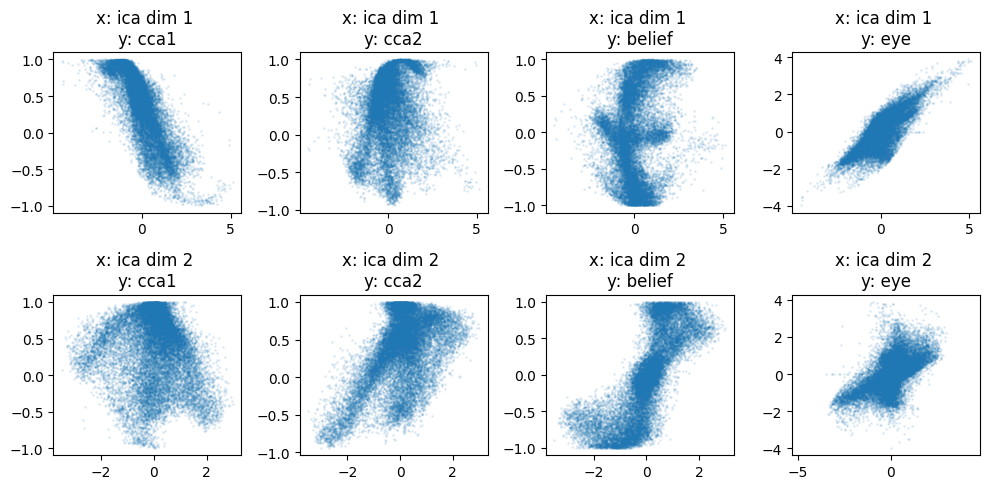

In [84]:

ica = FastICA(n_components=2)
icaX=np.hstack([embedding,related_taskvar])
icaS = ica.fit_transform(icaX) 

varname=['cca1','cca2','belief', 'eye']
fig, axs = plt.subplots(2,4, figsize=(10,5))
for i in range(2):
    for j in range(4):
        ax=axs[i,j]
        ax.scatter(icaS[:,i],icaX[:,j], s=1, alpha=0.1)
        plt.axis('equal')
        ax.set_title(f'x: ica dim {i+1} \ny: {varname[j]}')
plt.tight_layout()


### check, with other (potentially task irrelavent) task variables 

### CCA(neural activity, task variables)

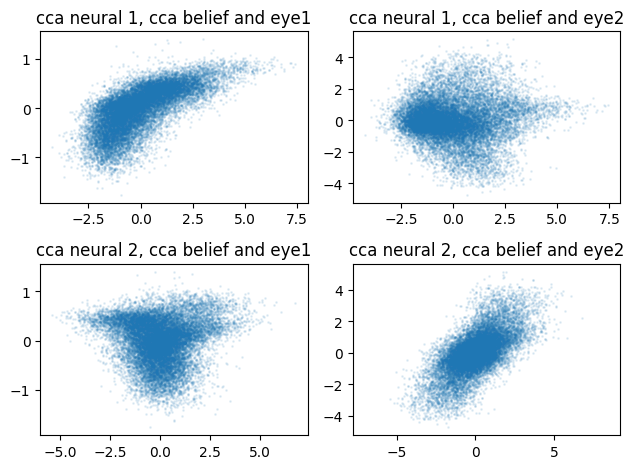

In [85]:
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import FastICA

cca = CCA(n_components=2)
related_taskvar=continuous_label
cca_neural, cca_be=cca.fit_transform(neural_data, related_taskvar)

fig, axs = plt.subplots(2,2)
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(cca_neural[:,i],cca_be[:,j], s=1, alpha=0.1)
        plt.axis('equal')
        ax.set_title(f'cca neural {i+1}, cca belief and eye{j+1}')
plt.tight_layout()

### ICA(cca latent, task variables)

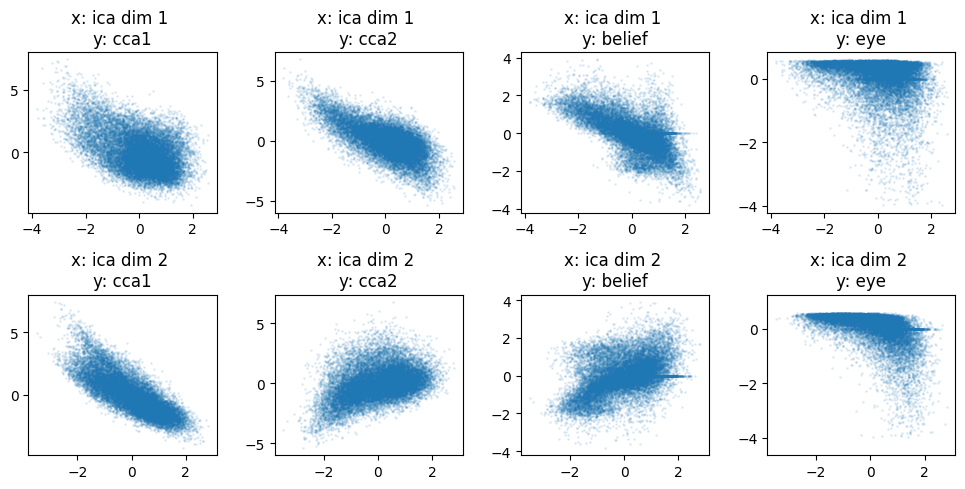

In [86]:

ica = FastICA(n_components=2)
icaX=np.hstack([cca_neural,related_taskvar])
icaS = ica.fit_transform(icaX) 

varname=['cca1','cca2','belief', 'eye']
fig, axs = plt.subplots(2,4, figsize=(10,5))
for i in range(2):
    for j in range(4):
        ax=axs[i,j]
        ax.scatter(icaS[:,i],icaX[:,j], s=1, alpha=0.1)
        plt.axis('equal')
        ax.set_title(f'x: ica dim {i+1} \ny: {varname[j]}')
plt.tight_layout()
